# Introduction

Short analysis and visual representasion of Public Holidays in Europe made in R.
The data has been downloaded from <a href="https://www.kaggle.com/prasertk/public-holidays-in-every-country-in-2022">this source</a>.



# 1. Data preparation

In [1]:
# Installing and running packages

install.packages("tidyverse")
install.packages("sqldf")
install.packages("maps")
install.packages("data.table")
library("tidyverse")
library("ggplot2")
library("sqldf")
library("data.table")
library("maps")

# Importing the datasets

public_holidays <- read_csv("../input/public-holidays-in-every-country-in-2022/holiday_calendar.csv")
regional_codes <- read.csv("../input/iso3166countrieswithregionalcodes/all.csv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“unable to access index for repository http://cran.rstudio.com/src/contrib:
  cannot open URL 'http://cran.rstudio.com/src/contrib/PACKAGES'”
Warning message:
“package ‘tidyverse’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“unable to access index for repository http://cran.rstudio.com/src/contrib:
  cannot open URL 'http://cran.rstudio.com/src/contrib/PACKAGES'”
Warning message:
“package ‘sqldf’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installi

In [2]:
#Previewing the data frames

head(public_holidays)
head(regional_codes)

Country,Country Code,Day,Date,Holiday Name,Type,Comments
<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<chr>
afghanistan,AF,Tuesday,2022-02-15,Liberation Day,National Holiday,NA
afghanistan,AF,Monday,2022-03-21,Nowrooz,National Holiday,Afghan New Year
afghanistan,AF,Tuesday,2022-03-22,Nowrooz Holiday,National Holiday,NA
afghanistan,AF,Sunday,2022-04-03,Ramadan,National Holiday,Expected Start of Ramadan
afghanistan,AF,Thursday,2022-04-28,Mujahideen Victory Day,National Holiday,NA
afghanistan,AF,Sunday,2022-05-01,Labour Day,National Holiday,International Workers' Day


,name,alpha.2,alpha.3,country.code,iso_3166.2,region,sub.region,intermediate.region,region.code,sub.region.code,intermediate.region.code
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>
1,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,,142,34,NA
2,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,,150,154,NA
3,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,,150,39,NA
4,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,,2,15,NA
5,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,,9,61,NA
6,Andorra,AD,AND,20,ISO 3166-2:AD,Europe,Southern Europe,,150,39,NA


# 2. Data processing

Dataset I'm using contains Public Holiday data for all countries in the world. It includes coutry names and country codes, but no continents. To extract data for Europe only, I'm going to merge this dataset with other, containing columns with country codes and continents. For this purpose I will use R package "sqldf", which will let me use SQL statements, such as LEFT JOIN.

In [3]:
#Renaming columns in public_holidays and regional_codes data frames

public_holidays <- rename(public_holidays, country = Country,
                          country_code1 = 'Country Code', weekday = Day,
                          date = Date, holiday_name = 'Holiday Name',
                          type = Type, comments = Comments)
regional_codes <- rename(regional_codes, country_code2 = alpha.2,
                         subregion = sub.region)

#Deleting unnecessary columns from regional_codes data frame using sqldf

regional_codes <- sqldf("SELECT country_code2, region, subregion
                    FROM regional_codes")

In [4]:
#Using sqldf to merge both data frames

public_holidays <- sqldf("SELECT *
                     FROM public_holidays
                     LEFT JOIN regional_codes
                     ON public_holidays.country_code1 = regional_codes.country_code2")

#Removing column country_code2 and renaming country_code1

public_holidays <- select(public_holidays, -c(country_code2))
public_holidays <- rename(public_holidays, country_code = country_code1)

head(public_holidays)

,country,country_code,weekday,date,holiday_name,type,comments,region,subregion
,<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>
1,afghanistan,AF,Tuesday,2022-02-15,Liberation Day,National Holiday,NA,Asia,Southern Asia
2,afghanistan,AF,Monday,2022-03-21,Nowrooz,National Holiday,Afghan New Year,Asia,Southern Asia
3,afghanistan,AF,Tuesday,2022-03-22,Nowrooz Holiday,National Holiday,NA,Asia,Southern Asia
4,afghanistan,AF,Sunday,2022-04-03,Ramadan,National Holiday,Expected Start of Ramadan,Asia,Southern Asia
5,afghanistan,AF,Thursday,2022-04-28,Mujahideen Victory Day,National Holiday,NA,Asia,Southern Asia
6,afghanistan,AF,Sunday,2022-05-01,Labour Day,National Holiday,International Workers' Day,Asia,Southern Asia


# 3. Data cleaning

In [5]:
#Counting null values in region column in the public_holidays data frame

count(public_holidays, is.na(region))

na_region_values <- public_holidays %>% 
  filter(is.na(region))
head(na_region_values)

is.na(region),n
<lgl>,<int>
FALSE,3884
TRUE,32


,country,country_code,weekday,date,holiday_name,type,comments,region,subregion
,<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>
1,kosovo,XK,Saturday,2022-01-01,New Year's Day,National Holiday,NA,NA,NA
2,kosovo,XK,Sunday,2022-01-02,Day after New Year's Day,National Holiday,NA,NA,NA
3,kosovo,XK,Monday,2022-01-03,New Year's Day (in lieu),National Holiday,NA,NA,NA
4,kosovo,XK,Friday,2022-01-07,Orthodox Christmas,National Holiday,NA,NA,NA
5,kosovo,XK,Thursday,2022-02-17,Independence Day,National Holiday,NA,NA,NA
6,kosovo,XK,Saturday,2022-04-09,Constitution Day,National Holiday,NA,NA,NA


In [6]:
#Seems that the data frame is missing region values for Kosovo and Namibia.
#Updating information for those countries

setDT(public_holidays)[country == "kosovo", region := "Europe"]
setDT(public_holidays)[country == "kosovo", subregion := "Southern Europe"]
setDT(public_holidays)[country == "namibia", region := "Africa"]
setDT(public_holidays)[country == "namibia", subregion := "Sub-Saharan Africa"]

count(public_holidays, is.na(region))

is.na(region),n
<lgl>,<int>
FALSE,3916


In [7]:
#Checking distinct values for types of holidays available in the data frame

public_holidays %>% 
  filter(region == "Europe") %>%
  distinct(type)

type
<chr>
National Holiday
Not A Public Holiday
Regional Holiday
Public Holiday
NA
Government Holiday
Bank Holiday


In this data set we have four types of holidays which we can categorize as general days of celebration for the whole country - "National Holiday", "Public Holiday", "Government Holiday" and "Bank Holiday". 
I'm going to have to investigate what hides behind types "Not A Public Holiday", "Regional Holiday" and N/A values.

In [8]:
#Checking "Not A Public Holiday", "Regional Holiday" and N/A values

holiday_check <- public_holidays %>% 
  filter(region == "Europe") %>% 
  filter(type == "Not A Public Holiday" | type == "Regional Holiday" | is.na(type)) %>% 
  arrange(type)
head(holiday_check)

country,country_code,weekday,date,holiday_name,type,comments,region,subregion
<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>
austria,AT,Sunday,2022-05-08,Mother's Day,Not A Public Holiday,2nd Sunday in May. Not a public holiday,Europe,Western Europe
austria,AT,Sunday,2022-06-12,Father's Day,Not A Public Holiday,2nd Sunday in June. Not a public holiday,Europe,Western Europe
belarus,BY,Sunday,2022-04-17,Easter Day (Catholic),Not A Public Holiday,NA,Europe,Eastern Europe
belarus,BY,Sunday,2022-04-24,Orthodox Easter Day,Not A Public Holiday,NA,Europe,Eastern Europe
belgium,BE,Thursday,2022-01-06,Three Kings' Day,Not A Public Holiday,Not a public holiday,Europe,Western Europe
belgium,BE,Sunday,2022-05-08,Mother's Day,Not A Public Holiday,2nd Sunday in May,Europe,Western Europe


After inspecting a new data frame containing "Not A Public Holiday", "Regional Holiday" and N/A values:
<ul style=“list-style-type:disc”>
    <li>"Not a public holiday" are mostly Mother's and Father's days, which usually aren't public holidays, so I'm going to filter them out </li>
    <li>"Regional Holidays" only apply to a specific region in a country. I decided to filter them out too, as they are not applicable to whole countries and it would be too much work to split every country by region.</li>
    <li>N/A values are missing types of holidays for Croatia, Finland, Greece, Malta, Macedonia and Poland. I'm going to check holidays for those countries in other sources and update information in my data frame.</li>
</ul>

In [9]:
#Updating missing values for Croatia, Finland, Greece, Malta, Macedonia and Poland

setDT(public_holidays)[country == "poland" & holiday_name != "Mother's Day" & holiday_name != "Father's Day",  type := "National Holiday"]
setDT(public_holidays)[country == "macedonia", type := "National Holiday"]
setDT(public_holidays)[country == "malta" & holiday_name != "Mother's Day" & holiday_name != "Father's Day",  type := "National Holiday"]
setDT(public_holidays)[country == "greece", type := "National Holiday"]
setDT(public_holidays)[country == "finland" & holiday_name != "Mother's Day" & holiday_name != "Father's Day",  type := "National Holiday"]
setDT(public_holidays)[country == "croatia", type := "National Holiday"]

In [10]:
#Filtering the data

europe_holidays <- public_holidays %>% 
  filter(region == "Europe") %>% 
  filter(country != "russia") %>% 
  filter(type != "Not A Public Holiday") %>% 
  filter(type != "Regional Holiday") %>% 
  arrange(country)

count(europe_holidays, is.na(type))
head(europe_holidays)

is.na(type),n
<lgl>,<int>
FALSE,648


country,country_code,weekday,date,holiday_name,type,comments,region,subregion
<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>
albania,AL,Saturday,2022-01-01,New Year's Day,National Holiday,NA,Europe,Southern Europe
albania,AL,Sunday,2022-01-02,Day after New Year's Day,National Holiday,NA,Europe,Southern Europe
albania,AL,Monday,2022-01-03,Day after New Year's Day (in lieu),National Holiday,NA,Europe,Southern Europe
albania,AL,Monday,2022-03-14,Summer Day,National Holiday,NA,Europe,Southern Europe
albania,AL,Monday,2022-03-21,Nevruz,National Holiday,Spring Festival,Europe,Southern Europe
albania,AL,Sunday,2022-04-17,Easter (Catholic),National Holiday,NA,Europe,Southern Europe


In [11]:
#Preparing to make a map; Changing country names in my data frame 
#Country names in original data set are lowercase and have dashes instead of spaces

europe_holidays$country <- gsub("-", " ", europe_holidays$country)
europe_holidays$country <- str_to_title(europe_holidays$country)

#Three exceptions; Changing Bosnia And Herzegovina" to "Bosnia and Herzegovina"
#Isle Of Man" to "Isle of Man" and"Macedonia" to "North Macedonia"

setDT(europe_holidays)[country == "Bosnia And Herzegovina", country := "Bosnia and Herzegovina"]
setDT(europe_holidays)[country == "Isle Of Man", country := "Isle of Man"]
setDT(europe_holidays)[country == "Macedonia", country := "North Macedonia"]

In [12]:
#Adding a month column

europe_holidays <- europe_holidays %>% 
  mutate(month = lubridate::month(date, label=TRUE, abbr=FALSE))

# 4. Data analysis & visualization

In [13]:
#Counting how many holidays each country has (top 10)

europe_holidays %>% 
  group_by(country) %>%
  summarise(n = n()) %>% 
  arrange(desc(n)) %>% 
  slice(1:10)

country,n
<chr>,<int>
Bulgaria,18
San Marino,18
Ukraine,18
Albania,17
Faroe Islands,17
Kosovo,17
Liechtenstein,17
Hungary,16
Lithuania,16


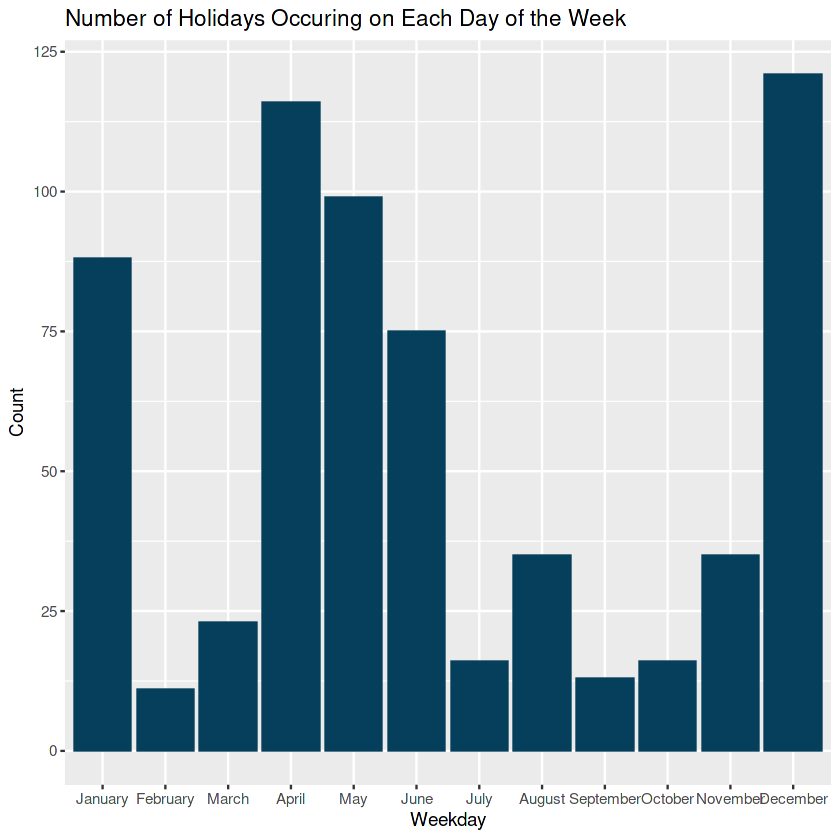

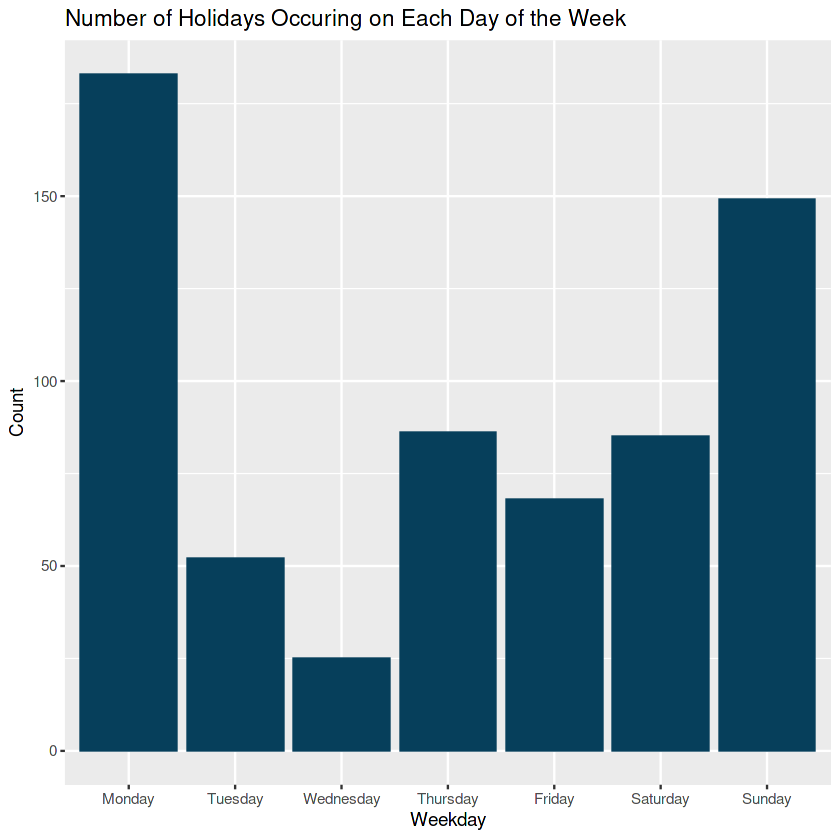

In [14]:
#Which month and weekday have the most holidays 

europe_holidays %>%
  group_by(month) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = month, y = count)) +
  geom_col(colour = "#063F5B", fill = "#063F5B") + 
  labs(y = "Count", x = "Weekday", title = "Number of Holidays Occuring on Each Day of the Week")

europe_holidays %>%
  group_by(weekday) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = factor(weekday, c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")), y = count)) +
  geom_col(colour = "#063F5B", fill = "#063F5B") + 
  labs(y = "Count", x = "Weekday", title = "Number of Holidays Occuring on Each Day of the Week")


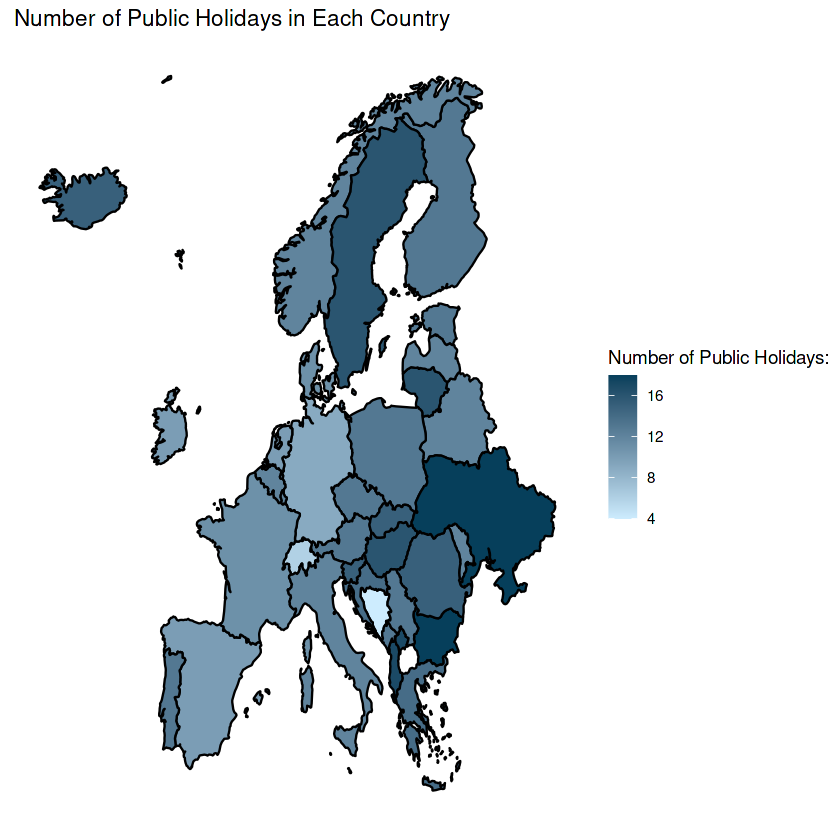

In [15]:
#Creating a map - downloading a world map data set, containing coordinates for all of the countries in the world

mapdata <- map_data("world")

#Renaming "region" column in map data data frame so it's the same as in our data table

mapdata <- mapdata %>% 
  rename(country = region)

#Creating a new data set from europe_holidays data frame,
#containing information on how many public holidays each country has

europe_count <- europe_holidays %>% 
  group_by(country) %>% 
  summarise(n = n())

#Joining new europe_count data frame with mapdata

mapdata <- left_join(mapdata, europe_count, by="country")

#Filtering out N/A values from the data frame

mapdata  <- mapdata %>% 
  filter(!is.na(mapdata$n))

#Unfortunately I'm going to remove region of Svalbard to make the map more clear

mapdata <- mapdata %>% 
  filter(subregion != "Svalbard" | is.na(subregion))

#Creating a map

map1 <- ggplot(mapdata, aes(x = long, y = lat, group = group)) +
  geom_polygon(aes(fill = n), color = "black")

map1 + scale_fill_gradient(name = "Number of Public Holidays:", low = "#CDECFE", high = "#063F5B", na.value = "grey50") +
labs(title = "Number of Public Holidays in Each Country") +
  theme(axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        rect = element_blank())

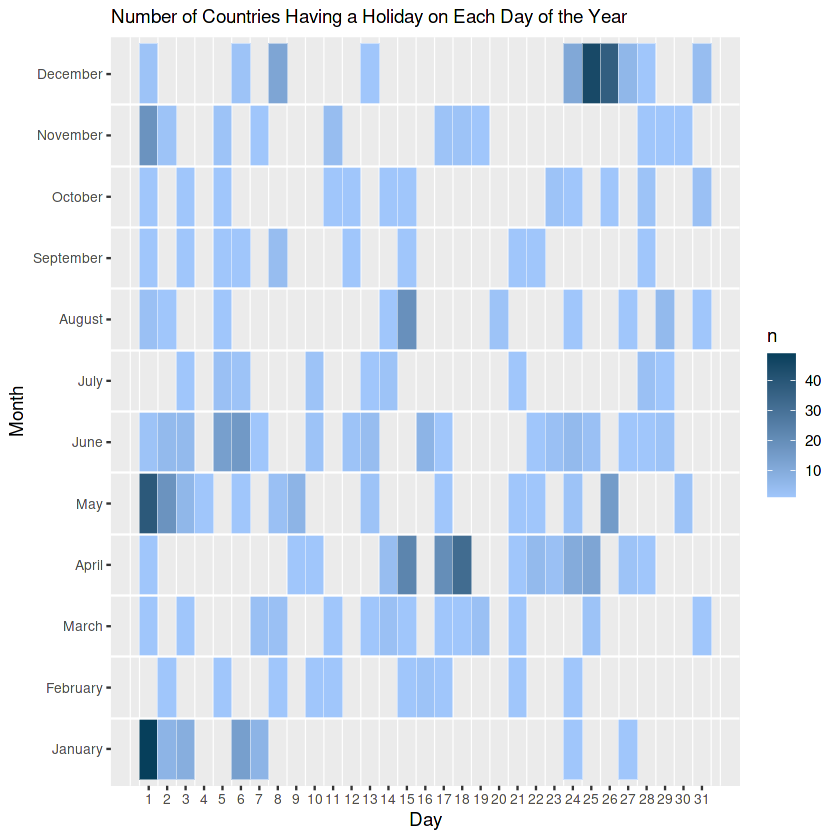

In [16]:
#Creating a visual representation of what days in a year have the most holidays (heatmap)
#First I have to make a new data frame, counting each time a certain date comes up in this data set

date_count <- europe_holidays %>% 
  count(date)

#Adding day and month columns to data_count

date_count <- date_count %>% 
  mutate(month = lubridate::month(date, label=TRUE, abbr=FALSE)) %>% 
  mutate(day = lubridate::day(date))

#Creating heatmap

ggplot(date_count, aes(x = day, y = month)) + geom_tile(aes(fill = n), colour = "white", na.rm = TRUE) +
  scale_fill_gradient(low = "#A0C6FB", high = "#063F5B", na.value = "grey50") +
  scale_x_continuous(breaks = seq(1, 31, by = 1)) +
  geom_hline(yintercept = c(1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5), color = "white") +
  labs(title = "Number of Countries Having a Holiday on Each Day of the Year",
       x = "Day", y = "Month") +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        axis.text = element_text(size = 8),
        plot.title = element_text(size = 11))

**Sources:**

<ul style=“list-style-type:disc”>
    <li><a href="https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes">https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes</a></li>
    <li><a href="https://rdocumentation.org/packages/sqldf/versions/0.4-11">https://rdocumentation.org/packages/sqldf/versions/0.4-11</a></li>
    <li><a href="https://publicholidays.eu">https://publicholidays.eu</a></li>
</ul>